In [4]:
from fastai import *
from fastai.vision.all import *
from models import conv, deconv

import sys
sys.path.append('..')
from src.band_plotters import *
from src.Tiff32Image import TiffImage, TiffImageNoised, AddNoiseTransform, RandomErasingTransform

In [5]:
NUMBER_OF_NEAR_BANDS = 12
SELECTED_WIDTH = 128

# from save_autoencoder_images:
MAX_ENERGY_MINUS_EFERMI =  20 # actually 30 but only 1 material exceeds 20
MIN_ENERGY_MINUS_EFERMI =  -17 # actually -100 but only 2 materials exceed -22 

## Load

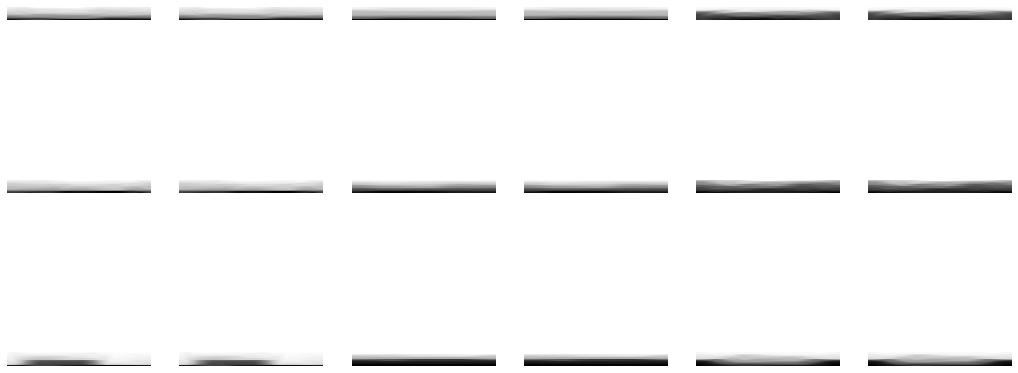

In [3]:
from fastai.vision.all import *

dls = DataBlock(
    blocks=(ImageBlock(cls=TiffImage), ImageBlock(cls=TiffImageNoised)), 
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.1),
    item_tfms=[Resize((12, SELECTED_WIDTH), "squish")],# AddNoiseTransform(std=1)], #RandomErasingTransform()], #AddNoiseTransform(std=1)],
    batch_tfms=[IntToFloatTensor(div=2**16-1)],
        ).dataloaders(DATA_DIRECTORY/f"images/energies_{NUMBER_OF_NEAR_BANDS}_nearest_bands", bs=64)

dls.show_batch()

In [4]:
xb, yb = dls.one_batch()
yb.max()

TensorImageNoised(0.7834, device='cuda:0')

(TensorImageBW(0.3023, device='cuda:0'),
 TensorImageBW(0.6276, device='cuda:0'))

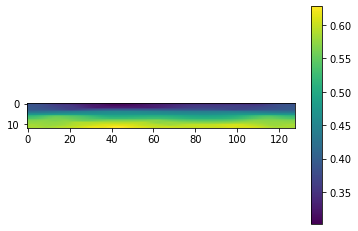

In [5]:
i=4
plt.imshow(xb[i][0].cpu()) 
plt.colorbar()
xb[i].min(), xb[i].max()

## Train

### Create Learner

In [6]:
from models import SimpleAutoencoder

epoch,train_loss,valid_loss,time
0,0.003896,0.005667,00:10
1,0.002372,0.005830,00:11
2,0.001409,0.008904,00:12
3,0.000875,0.009470,00:13
4,0.000647,0.002946,00:11
5,0.000506,0.001866,00:11
6,0.000404,0.005331,00:11
7,0.000381,0.001039,00:11
8,0.000357,0.007605,00:10
9,0.000324,0.000814,00:09


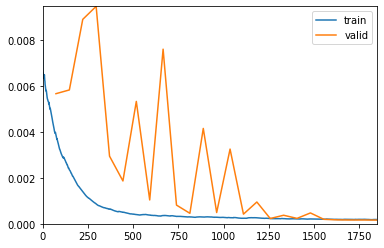

epoch,train_loss,valid_loss,time
0,0.006022,0.006594,00:10
1,0.003640,0.004301,00:11
2,0.001964,0.002956,00:11
3,0.001221,0.018267,00:09
4,0.000857,0.005017,00:09
5,0.000627,0.007481,00:10
6,0.000475,0.001252,00:11
7,0.000367,0.001065,00:11
8,0.000323,0.001239,00:10
9,0.000283,0.000879,00:10


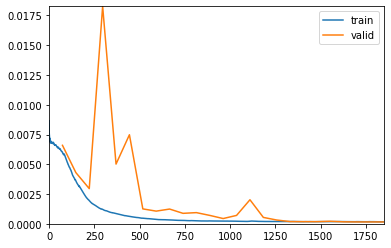

epoch,train_loss,valid_loss,time
0,0.004807,0.006141,00:11
1,0.002709,0.004465,00:07
2,0.001644,0.004976,00:06
3,0.001115,0.006384,00:07
4,0.000796,0.003682,00:08
5,0.000602,0.009938,00:07
6,0.000465,0.001390,00:07
7,0.000373,0.000821,00:07
8,0.000307,0.000861,00:07
9,0.000312,0.000756,00:07


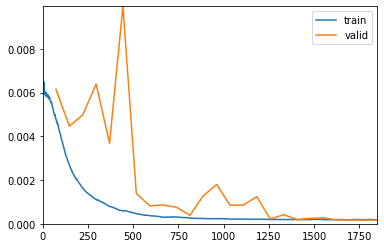

epoch,train_loss,valid_loss,time
0,0.006380,0.006703,00:06
1,0.004221,0.005389,00:06
2,0.002186,0.003358,00:08
3,0.001199,0.001645,00:09
4,0.000789,0.001288,00:11
5,0.000648,0.002569,00:09
6,0.000543,0.000701,00:10
7,0.000523,0.004633,00:11
8,0.000458,0.000706,00:12
9,0.000438,0.002185,00:12


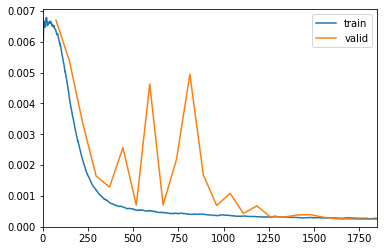

epoch,train_loss,valid_loss,time
0,0.006612,0.006792,00:09
1,0.004450,0.007479,00:08
2,0.002292,0.002892,00:09
3,0.001455,0.009311,00:10
4,0.000989,0.001522,00:10
5,0.000761,0.012870,00:09
6,0.000615,0.001162,00:09
7,0.000570,0.004536,00:09
8,0.000515,0.001106,00:09
9,0.000478,0.001532,00:09


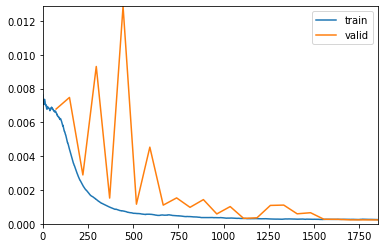

epoch,train_loss,valid_loss,time
0,0.006232,0.006400,00:07
1,0.004307,0.003869,00:07
2,0.002808,0.005898,00:07
3,0.001554,0.002427,00:06
4,0.000958,0.001579,00:05
5,0.000720,0.006689,00:05
6,0.000616,0.002023,00:08
7,0.000544,0.000873,00:11
8,0.000476,0.001210,00:10
9,0.000438,0.000646,00:11


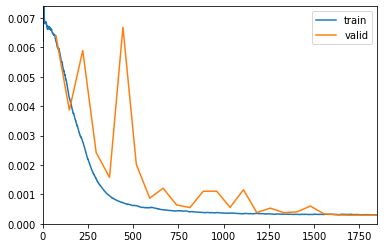

epoch,train_loss,valid_loss,time
0,0.005226,0.005664,00:11
1,0.003713,0.004452,00:11
2,0.002888,0.004106,00:13
3,0.002098,0.004121,00:12
4,0.001465,0.002816,00:12
5,0.001089,0.006719,00:11
6,0.000881,0.001215,00:11
7,0.000760,0.001805,00:13
8,0.000678,0.001847,00:13
9,0.000556,0.000957,00:13


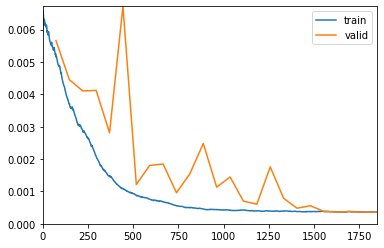

epoch,train_loss,valid_loss,time
0,0.005632,0.006077,00:10
1,0.004094,0.005018,00:13
2,0.002858,0.008271,00:12
3,0.002002,0.005195,00:11
4,0.001488,0.001735,00:11
5,0.001185,0.003063,00:12
6,0.000961,0.002543,00:11
7,0.000865,0.000973,00:12
8,0.000771,0.001294,00:12
9,0.000740,0.002570,00:15


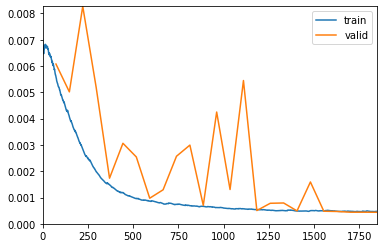

In [7]:
n_latents = [256, 128, 64, 32, 16, 8, 4, 2]

for n in n_latents:
    ae = SimpleAutoencoder(n_latent=n)
    learn = Learner(dls, ae, F.mse_loss, cbs=[ShowGraphCallback()])
    learn.fit_one_cycle(25)
    learn.export(f"trained_models/nearest_12_v1_length_{n}.pkl")

## View Predictions

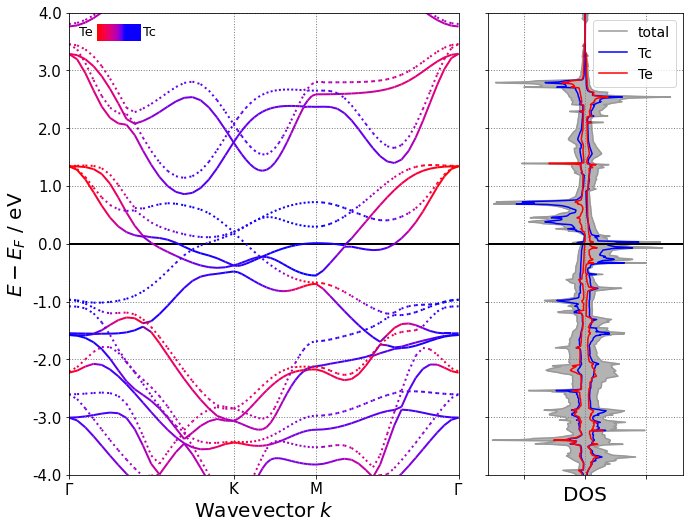

In [11]:
plot("2dm-7")

array([<AxesSubplot:title={'center':'Input'}>,
       <AxesSubplot:title={'center':'Reconstruction'}>], dtype=object)

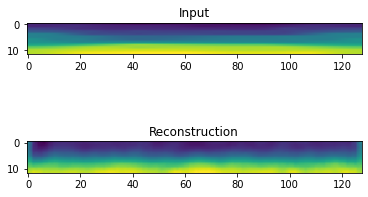

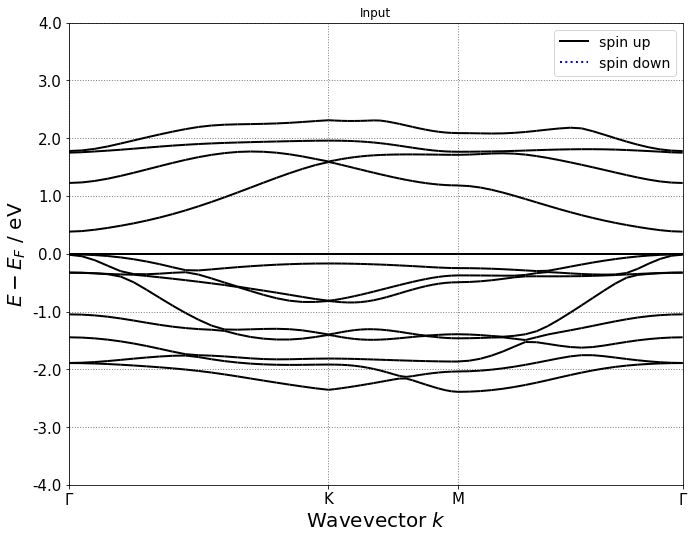

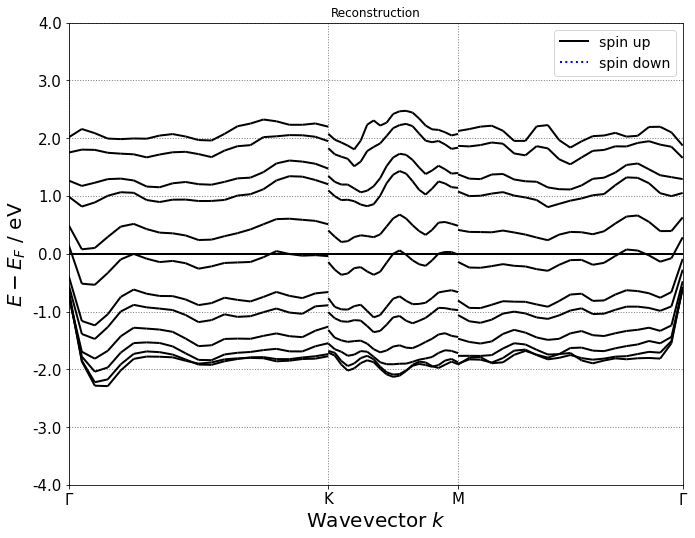

In [17]:
view_prediction("2dm-26", learn.model, MIN_ENERGY_MINUS_EFERMI, MAX_ENERGY_MINUS_EFERMI, width=SELECTED_WIDTH)

In [6]:
learn1 = load_learner("trained_models/nearest_12_v1_length_32.pkl")

AttributeError: Custom classes or functions exported with your `Learner` not available in namespace.\Re-declare/import before loading:
	Can't get attribute 'SimpleAutoencoder' on <module '__main__'>

In [7]:
view_prediction("2dm-26", learn1.model, MIN_ENERGY_MINUS_EFERMI, MAX_ENERGY_MINUS_EFERMI, width=SELECTED_WIDTH)

NameError: name 'learn1' is not defined

In [10]:
from torchvision.transforms import RandomErasing
o = Tiff32Image.create(DATA_DIRECTORY/f"images/energies_{NUMBER_OF_NEAR_BANDS}_nearest_bands"/"2dm-1.tiff")
x, y, h, w, v = RandomErasing.get_params(o, scale=0.5, ratio=(0.3, 3.3), value=0)
    # return F.erase(o, x, y, h, w, v)

IndexError: tuple index out of range